# Analisis de PCB.

In [2]:
# Cargar librerias.
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

Vamos a definir funciones que nos serán utiles para una mejor manipulación de las imagenes.

In [3]:
def mostrar_imagen(titulo, imagen):
    plt.figure(figsize=(10,8))
    plt.imshow(imagen, cmap='gray')
    plt.title(titulo)
    plt.axis('off')
    plt.show()

def mostrar_histograma(titulo, imagen):
    # calcHist([imagen], [canal], máscara, [tamaño_hist], [rango])
    hist = cv.calcHist([imagen], [0], None, [256], [0,256])

    plt.figure(figsize=(10,4))
    plt.plot(hist, color='black')
    plt.title(titulo)
    plt.xlabel('Intensidad de Píxel (0=Negro, 255=Blanco)')
    plt.ylabel('Cantidad de Píxeles')
    plt.xlim([0,256])
    plt.grid(True)
    plt.show()

¿Cómo son nuestras imagenes?

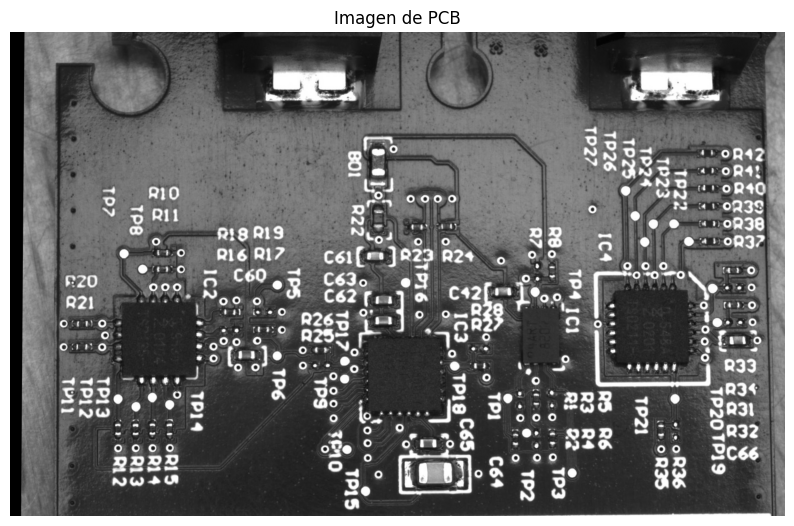

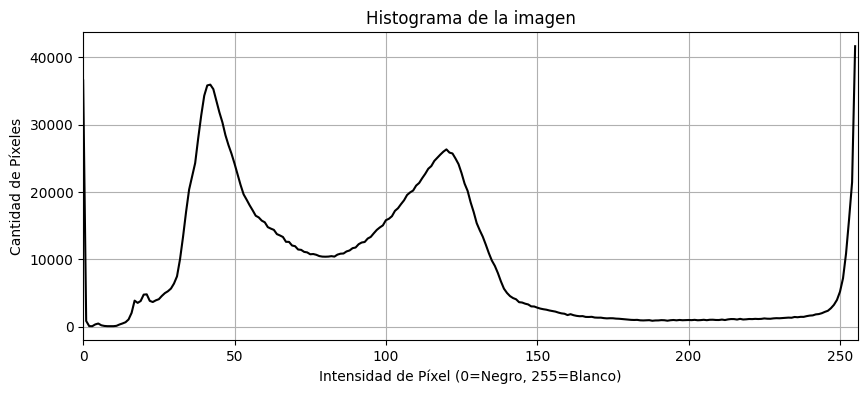

In [6]:
img_pcb = cv.imread('datasets_piezas_te/izumi_resistors/output1223.jpg', cv.IMREAD_GRAYSCALE)

mostrar_imagen('Imagen de PCB', img_pcb)
mostrar_histograma('Histograma de la imagen', img_pcb)

El histograma nos muestra la distribución de la intesndiad de los píxeles en una imagen.

# 1. Histograma y contastes.

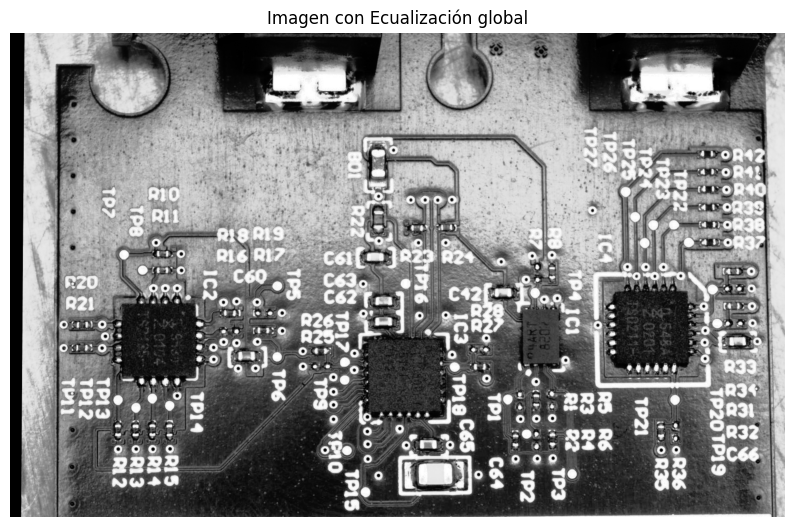

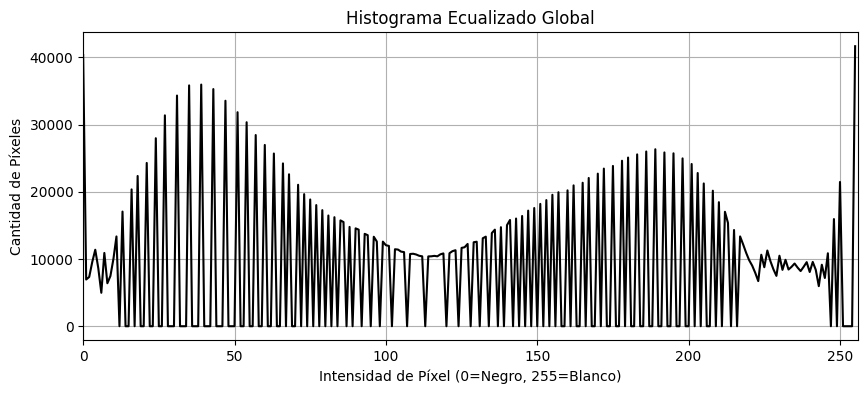

In [8]:
img_eq_global = cv.equalizeHist(img_pcb)

# Comparemos la imagen y el nuevo histograma
mostrar_imagen('Imagen con Ecualización global', img_eq_global)
mostrar_histograma('Histograma Ecualizado Global', img_eq_global)

**¿Cómo se ve la imagén?**
**¿Por qué falla?**

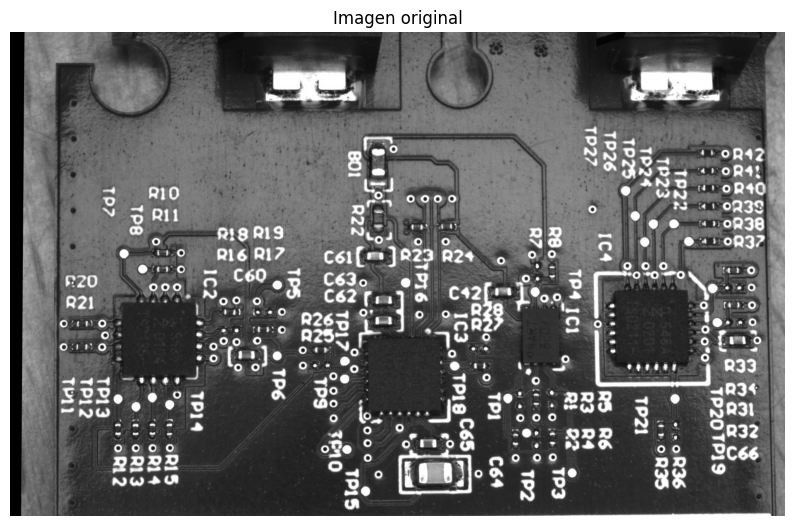

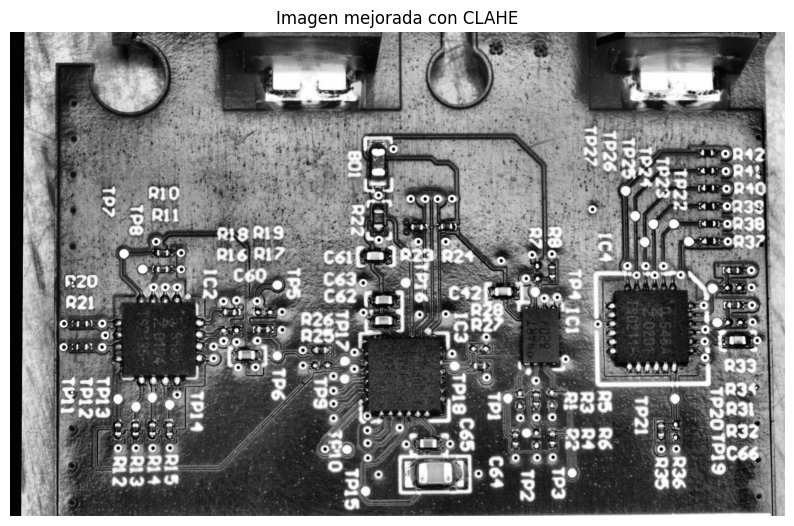

In [ ]:
# Creamos objeto CLAHE
# clipLimit: Limite de contraste. Un valor bajo (2.0-5.0) evita que el ruido se dispare
# tileGridSize: El tamaño de la cuadricula. (8,8) es un estándar.
clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))

img_clahe = clahe.apply(img_pcb)

mostrar_imagen('Imagen original', img_pcb)
mostrar_imagen('Imagen mejorada con CLAHE', img_clahe)

**¿Por qué mejoró el contraste a diferencia de la ecualización?**

# 2. Umbralado (Thresholding).

Valor de umbral óptimo (Otsu) global: 117.0


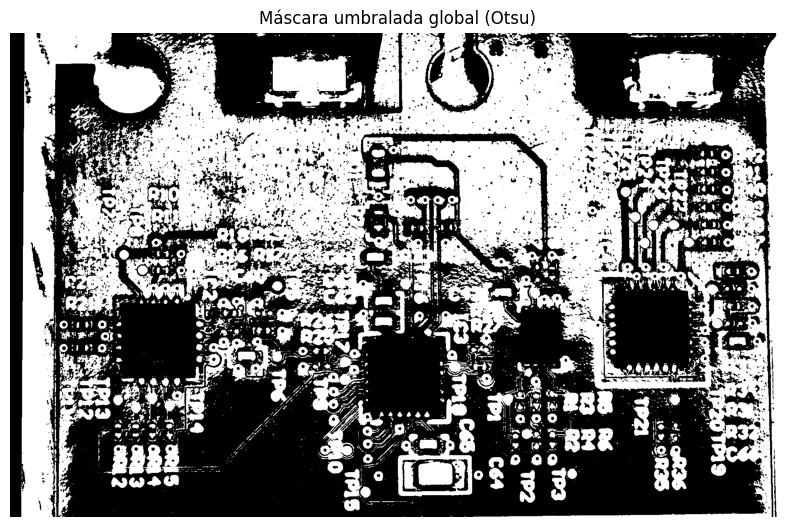

In [10]:
# Umbralado global
ret, mask_global_otsu = cv.threshold(
    img_clahe,
    0,
    255,
    cv.THRESH_BINARY + cv.THRESH_OTSU
)

print(f'Valor de umbral óptimo (Otsu) global: {ret}')
mostrar_imagen('Máscara umbralada global (Otsu)', mask_global_otsu)

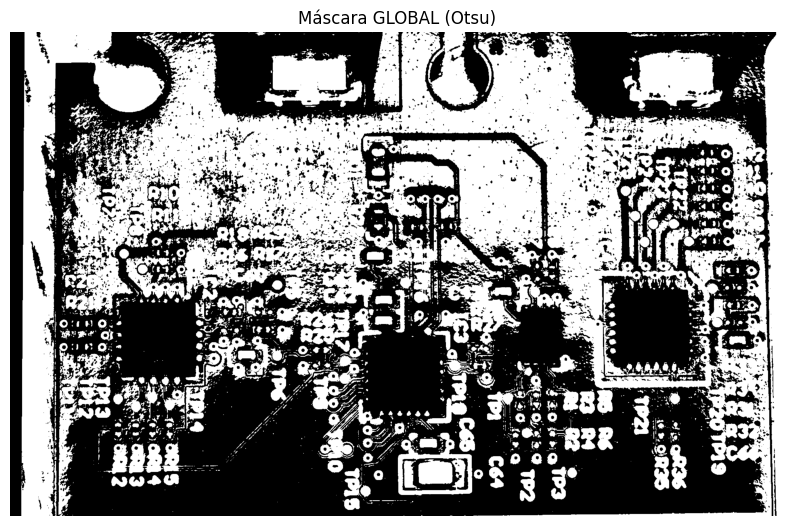

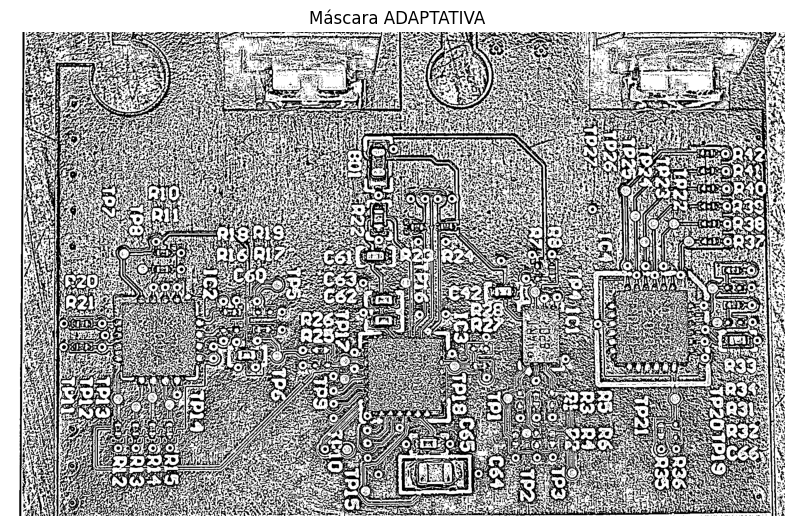

In [11]:
# Umbralado adaptativo

mask_adaptive = cv.adaptiveThreshold(
    img_clahe,
    255,
    cv.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv.THRESH_BINARY,
    11,
    2
)

# Comparamos
mostrar_imagen('Máscara GLOBAL (Otsu)', mask_global_otsu)
mostrar_imagen('Máscara ADAPTATIVA', mask_adaptive)

# 3. Filtros para reducción de ruido y suavizado.

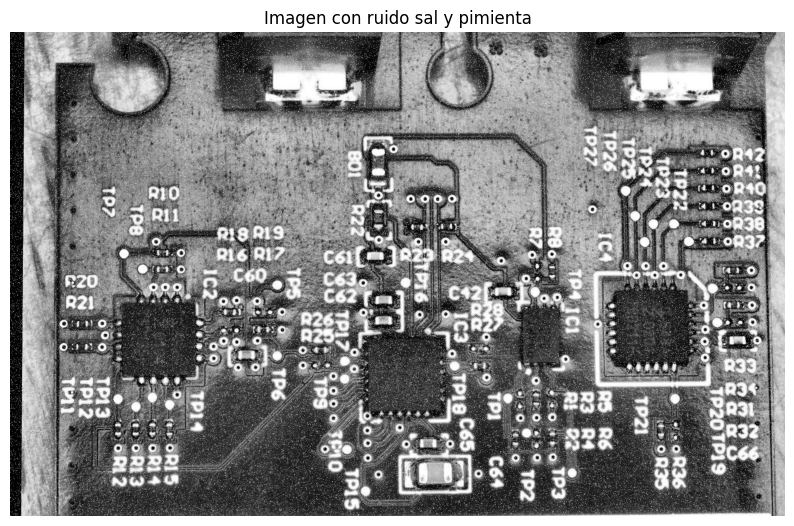

In [20]:
# Vamos a preparar una imagen con ruido para ver los efectos de los filtors.

import numpy as np

def agregar_ruido_sal_pimienta(imagen, prob):
    img_ruidosa = np.copy(imagen)
    total_pixeles = imagen.size

    num_pimienta = int(total_pixeles * (prob / 2))
    coords_pimienta = [np.random.randint(0, i - 1, num_pimienta) for i in imagen.shape]
    img_ruidosa[tuple(coords_pimienta)] = 255

    return img_ruidosa

img_con_ruido = agregar_ruido_sal_pimienta(img_clahe, 0.09)
mostrar_imagen('Imagen con ruido sal y pimienta', img_con_ruido)

Filtro de Media (Blur)

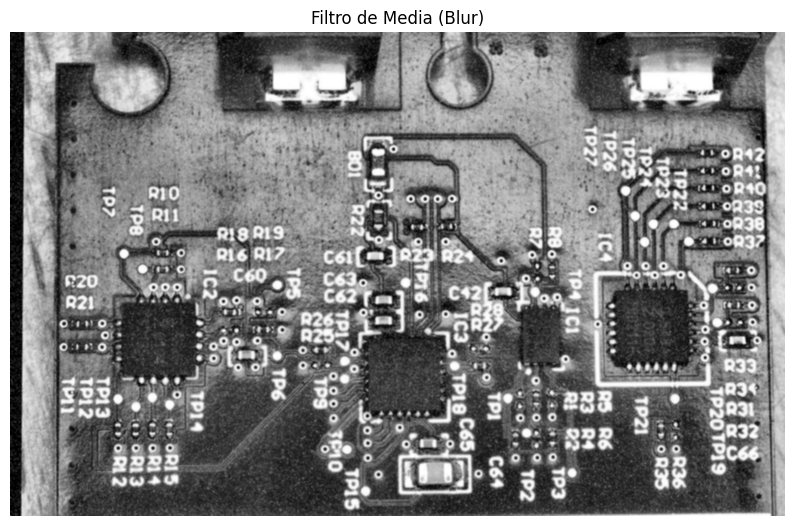

In [21]:
img_media = cv.blur(img_con_ruido, (5,5))

mostrar_imagen('Filtro de Media (Blur)', img_media)

Filtro Gaussiano.

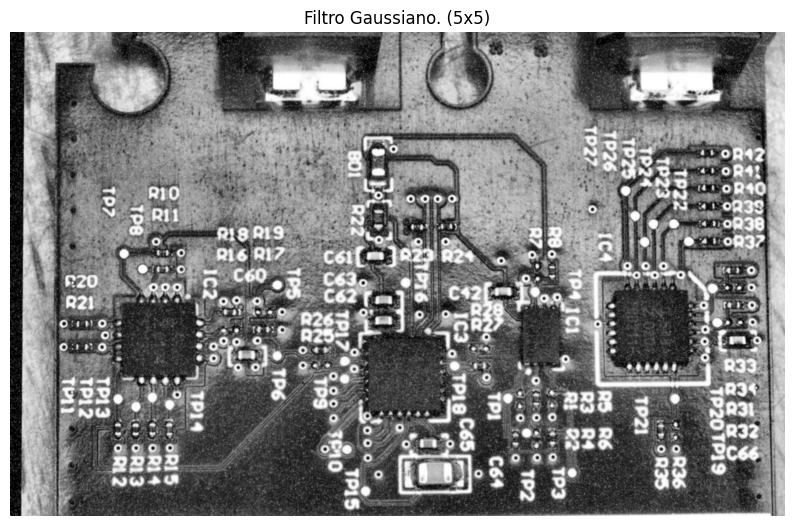

In [22]:
img_gaussiana = cv.GaussianBlur(img_con_ruido, (5,5), 0)

mostrar_imagen('Filtro Gaussiano. (5x5)', img_gaussiana)

Filtro de mediana.

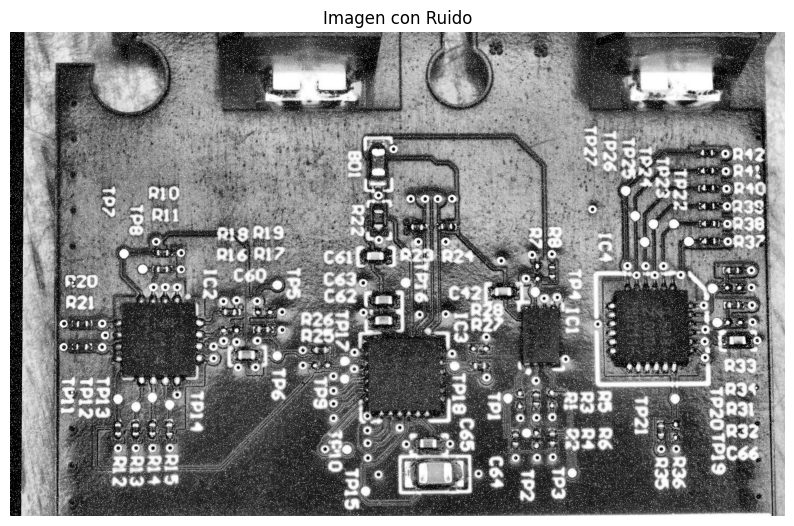

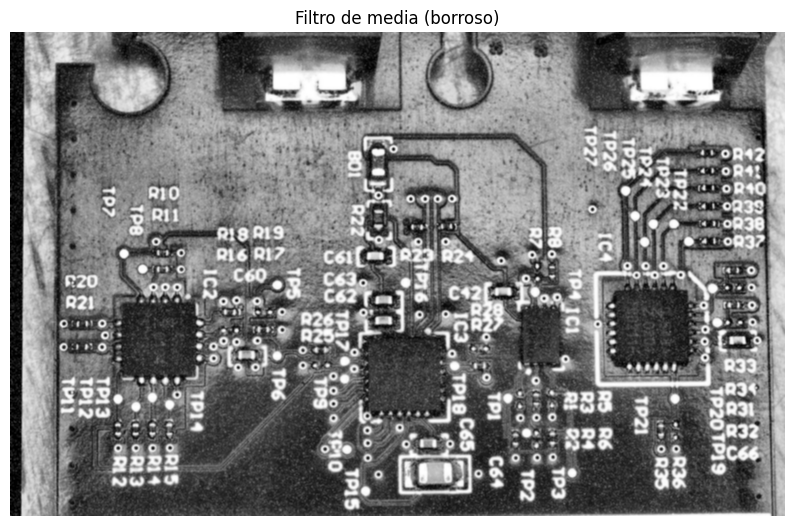

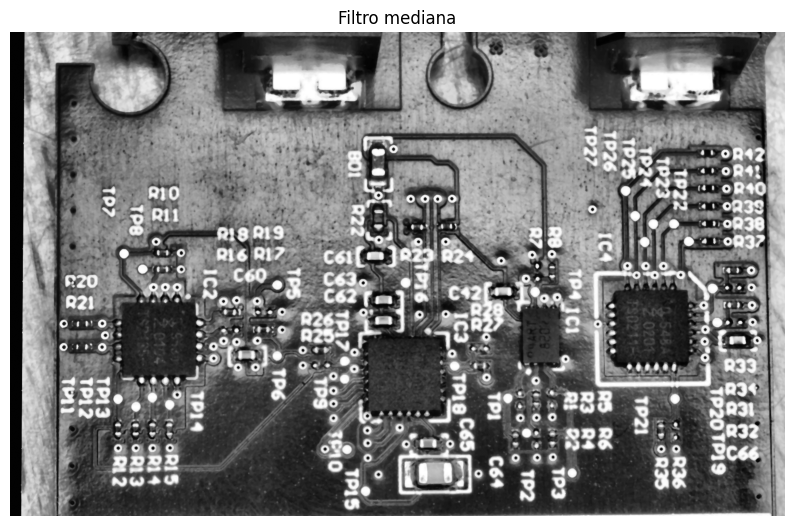

In [23]:
img_mediana = cv.medianBlur(img_con_ruido, 5)

mostrar_imagen('Imagen con Ruido', img_con_ruido)
mostrar_imagen('Filtro de media (borroso)', img_media)
mostrar_imagen('Filtro mediana', img_mediana)

**¿Por qué funciona tan bien?**

# 4. Detección de Objetos (Pattern Matching).

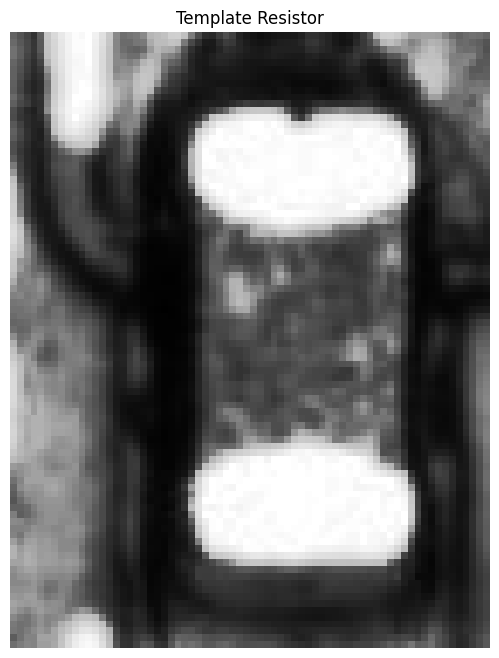

Dimensiones de la plantilla: Alto=90, Ancho=70


In [40]:
y1, y2 = 280, 370
x1, x2 = 870, 940

template_resistor = img_clahe[y1:y2, x1:x2]

mostrar_imagen('Template Resistor', template_resistor)

h, w = template_resistor.shape
print(f"Dimensiones de la plantilla: Alto={h}, Ancho={w}")

Aplicamos template matching con la plantilla.

Mejor coincidencia encontrada con una confianza de : 1.0000 en la posición 100.00%
Ubicación (esquina superior izquierda): (870, 280)


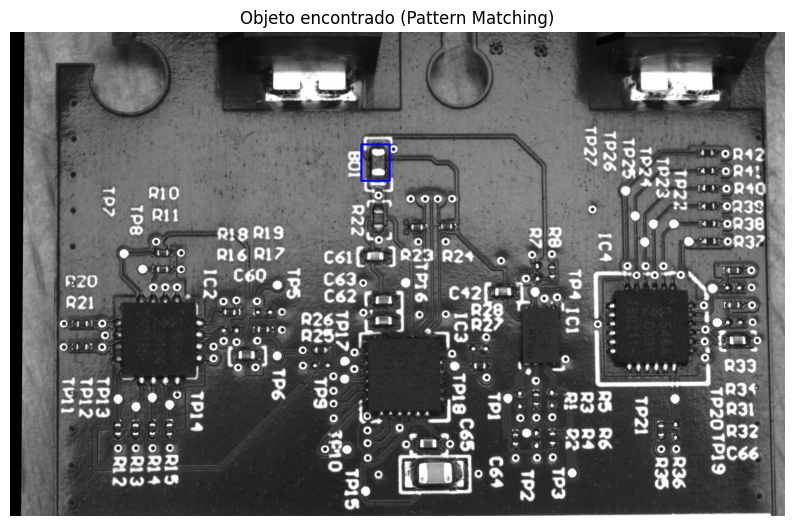

In [42]:
res = cv.matchTemplate(img_clahe, template_resistor, cv.TM_CCOEFF_NORMED)

# Encontramos el punto de máxima coincidencia en el mapa de calor.
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

print(f"Mejor coincidencia encontrada con una confianza de : {max_val:.4f} en la posición {max_val*100:.2f}%")
print(f"Ubicación (esquina superior izquierda): {max_loc}")

top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)

img_resultado = cv.cvtColor(img_pcb, cv.COLOR_GRAY2BGR)

cv.rectangle(
    img_resultado,
    top_left,
    bottom_right,
    (0,0,255),
    3
)

mostrar_imagen('Objeto encontrado (Pattern Matching)', img_resultado)

**¿Qué pasaría si quiero encontrar las otras resistencias?**